#### TIC ID's

- success 01: TIC 248853232 (gas giant)
- success 02: TIC 86263325 (gas giant)
- success 03: TIC 427685831 (gas giant)
- success 04: TIC 455784423 (gas giant)
- success 05: TIC 243921117 (gas giant)
- success 06: TIC 21744120 (gas giant)
- success 07: TIC 198108326 (gas giant)
- success 08: TIC 158588995 (neptune like)
- success 09: TIC 19028197 (neptune like)
- success 10: TIC 259377017 (sub neptune, 2 super earths)

gas giant > 6 R🜨 > neptune like > 4 R🜨 > sub neptune > 2 R🜨 > super earth > 1.5 R🜨 > terrestrial

In [1]:
TIC = str(f"TIC {input("TIC: ")}")

TIC:  259377017


In [2]:
%matplotlib widget
import statistics
import matplotlib.pyplot as plt
import lightkurve as lk
import numpy as np
from scipy import stats
from astropy import units as u
from astropy import constants as const
from astroquery.mast import Catalogs

In [3]:
def import_data(TIC):    
    all_data = lk.search_lightcurve(TIC, author = "SPOC", exptime = "short")

    sectors_list = []
    for sector in all_data.table:
        sectors_list.append(int(sector["sequence_number"]))

    all_years = []
    for each in all_data:
        all_years.append(each.year.item())

    yr_max_i = np.max(range(len(all_years)))
    yr_max = (all_years[yr_max_i])
    yr_min = (all_years[0])
    yr_range = yr_max - yr_min

    if yr_range > 5:
        yr_count = np.bincount(all_years)
        yr_mode = np.argmax(yr_count)
        yr_median = np.median(all_years)

        if np.max(yr_count) > 5:
            year_mask = (all_data.table["year"] >= yr_mode - 1) & (all_data.table["year"] <= yr_mode + 1)
        else:
            year_mask = (all_data.table["year"] >= yr_median - 1) & (all_data.table["year"] <= yr_median + 1)
                
        selected_data = all_data[year_mask]
        stitch_me = lk.search_lightcurve(TIC, author = "SPOC", exptime = "short", sector = sectors_list)[year_mask].download_all()
    else:
        selected_data = all_data
        stitch_me = lk.search_lightcurve(TIC, author = "SPOC", exptime = "short", sector = sectors_list).download_all()
    
    return all_data, sectors_list, selected_data, stitch_me
all_data, sectors, selected_data, stitch_me = import_data(TIC)

print("all data:")
print(all_data)
print("\nselected data:")
print(selected_data)

all data:
SearchResult containing 6 data products.

 #     mission     year author exptime target_name distance
                                  s                 arcsec 
--- -------------- ---- ------ ------- ----------- --------
  0 TESS Sector 03 2018   SPOC     120   259377017      0.0
  1 TESS Sector 04 2018   SPOC     120   259377017      0.0
  2 TESS Sector 05 2018   SPOC     120   259377017      0.0
  3 TESS Sector 30 2020   SPOC     120   259377017      0.0
  4 TESS Sector 32 2020   SPOC     120   259377017      0.0
  5 TESS Sector 97 2025   SPOC     120   259377017      0.0

selected data:
SearchResult containing 5 data products.

 #     mission     year author exptime target_name distance
                                  s                 arcsec 
--- -------------- ---- ------ ------- ----------- --------
  0 TESS Sector 03 2018   SPOC     120   259377017      0.0
  1 TESS Sector 04 2018   SPOC     120   259377017      0.0
  2 TESS Sector 05 2018   SPOC     120   259377017

<Axes: xlabel='Pixel Column Number', ylabel='Pixel Row Number'>

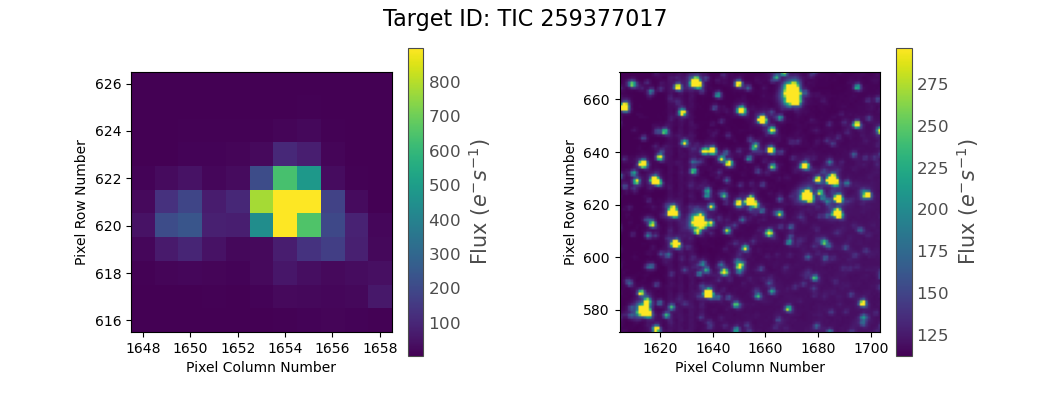

In [4]:
fig, (ax1, ax2) = plt.subplots(nrows = 1 ,ncols = 2, figsize = (10.5, 4))
fig.suptitle(f"Target ID: {TIC}", fontsize = 16)
fig.subplots_adjust(wspace = .5)

px_file = lk.search_targetpixelfile(TIC, author = "SPOC", exptime = "short", sector = sectors[0]).download()
px_file.plot(ax = ax1, title = "")

ff_file = lk.search_tesscut(TIC, sector = sectors[0]).download(cutout_size = 99)
ff_file.plot(ax = ax2, title = "")

<Axes: xlabel='Time - 2457000 [BTJD days]', ylabel='Flux [$\\mathrm{e^{-}\\,s^{-1}}$]'>

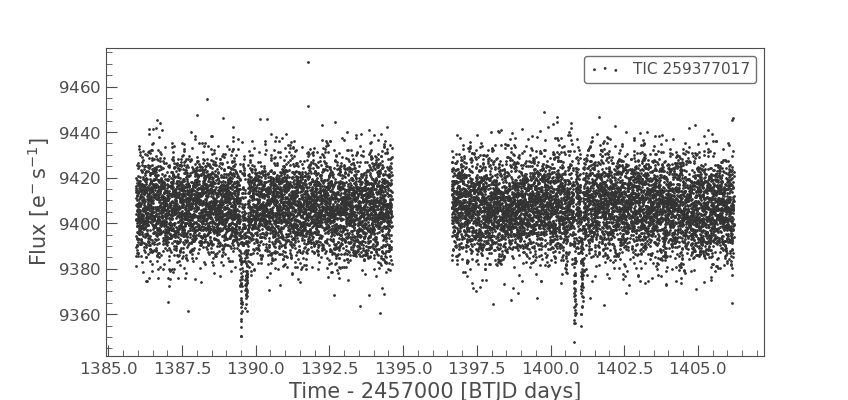

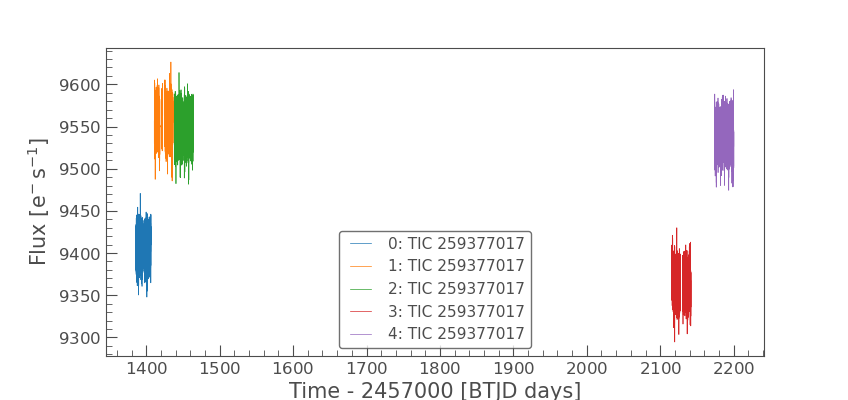

In [5]:
ts_first = lk.search_lightcurve(TIC, author = "SPOC", exptime = "short", sector = sectors[0]).download()

if len(sectors) > 1:
    fold_me = stitch_me.stitch().flatten().remove_nans()
else:
    fold_me = ts_first.flatten().remove_nans()

ts_first.scatter()
stitch_me.plot()

candidate 1 orbital period: 5.6606 days
candidate 2 orbital period: 11.3797 days
candidate 3 orbital period: 3.3602 days


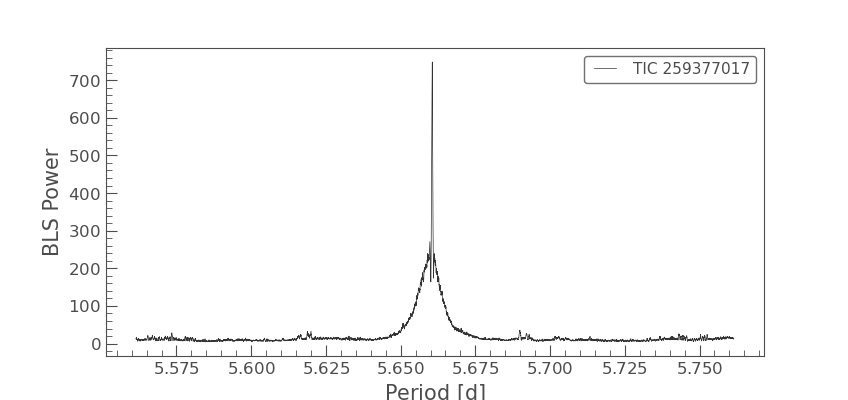

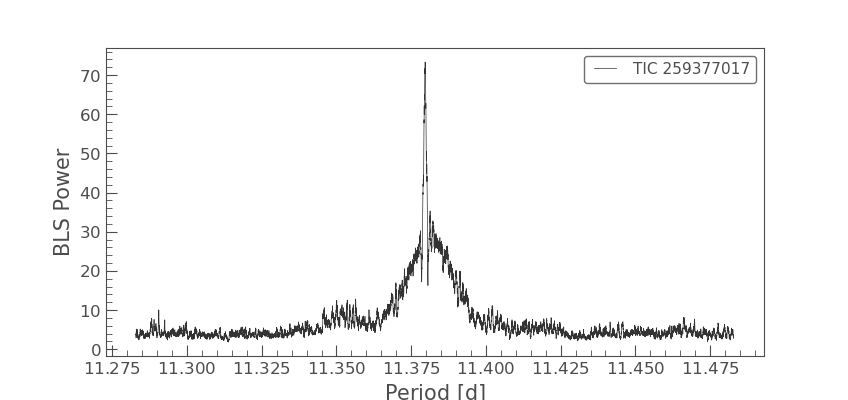

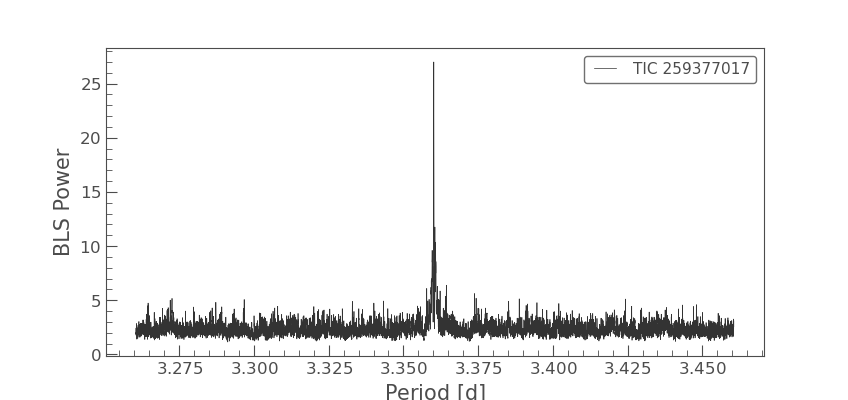

In [6]:
def initial_periodogram(fold_me, exclusions, i):
    search_duration = np.linspace(.05, .4, 10)
    search_period = np.logspace(np.log10(1), np.log10(14), 5000) 
    periodogram = fold_me.to_periodogram(method = "bls", period = search_period, duration = search_duration, frequency_factor = 500)
    
    #if exclusions:
    #    for each in exclusions:
    #        periodogram.power[~each] = 0
            
    orbital_period = periodogram.period_at_max_power
    transit_time = periodogram.transit_time_at_max_power
    transit_duration = periodogram.duration_at_max_power  
    return periodogram, orbital_period, transit_time, transit_duration
    
def refine_periodogram(prev_fold_me, prev_period, prev_duration):
    duration = np.linspace(prev_duration.value - .01, prev_duration.value + .01, 30) 
    period = np.linspace(prev_period.value - .1, prev_period.value + .1, 15000)
    final_periodogram = prev_fold_me.to_periodogram(method = "bls", period = period, duration = duration)
    final_period = final_periodogram.period_at_max_power
    final_time = final_periodogram.transit_time_at_max_power
    final_duration = final_periodogram.duration_at_max_power
    return final_periodogram, final_period, final_time, final_duration\
    
def test_harmonics(prev_fold_me, prev_period, prev_time):
    phased_lc = prev_fold_me.fold(period = prev_period, epoch_time = prev_time)
    binned_lc = phased_lc.bin(30/60/24)
    
    greatest_min = binned_lc.flux.value.min()
    transit_depth = 1 - greatest_min
    transit_threshold = greatest_min + (transit_depth * .35)
    below = (binned_lc.flux.value < transit_threshold)
    min_duration = 2
    transit_length = 0
    transit_count = 0

    for flux in below:
        if flux:
            transit_length += 1
        elif transit_length >= min_duration:
            transit_count += 1
            transit_length = 0

    if transit_count == 1:
        detected_planet = True
    else:
        detected_planet = False
    return detected_planet, phased_lc

#def semi_major_axis(prev_period):
#    star_mass = Catalogs.query_object(TIC, catalog = "TIC")["mass"][0]
#    #sma = ((const.G*star_mass*(prev_period**2))/(4*(np.pi**2)))**(1/3)
#    sma = (((star_mass/const.M_sun)*(prev_period/365))**(1/3))*(const.au)
#    return sma
    
def next_function(prev_fold_me, prev_periodogram, prev_period, prev_time, prev_duration):
    mask = prev_periodogram.get_transit_mask(period = prev_period, transit_time = prev_time, duration = prev_duration)
    next_fold_me = prev_fold_me[~mask]

    exclude = (prev_periodogram.period < prev_period * .95) | (prev_periodogram.period > prev_period * 1.05) 
    prev_periodogram.power[~exclude] = 0
    return next_fold_me, exclude

candidates = [fold_me]
exclusions = []
exoplanets = []

i = 0
potential_candidate = True
while potential_candidate:
    periodogram, orbital_period, transit_time, transit_duration = initial_periodogram(candidates[i], exclusions, i) 
    final_periodogram, final_period, final_time, final_duration = refine_periodogram(candidates[i], orbital_period, transit_duration)
    
    detected_planet, phased_lc = test_harmonics(candidates[i], final_period, final_time)
    if detected_planet == True:
        #sma = semi_major_axis(final_period)
        #print(f"candidate {i + 1} semi major axis: {sma}")
        print(f"candidate {i + 1} orbital period: {round(final_period.value, 4)} days")
        final_periodogram.plot()
        exoplanets.append({"period": final_period, "t0": final_time, "duration": final_duration})   #, "sma": sma})
        
    next_fold_me, exclude = next_function(candidates[i], final_periodogram, final_period, final_time, final_duration)
    candidates.append(next_fold_me)
    exclusions.append(exclude)     
    if i != 0:
        redundant_check = candidates[i].fold(period = orbital_period, epoch_time = transit_time)
        center = (-0.01 * u.day < redundant_check.phase) & (redundant_check.phase < 0.01 * u.day)
        if np.median(redundant_check.flux[center]) > 0 and periodogram.max_power > 10: 
            potential_candidate = True
        else:
            potential_candidate = False
    i += 1

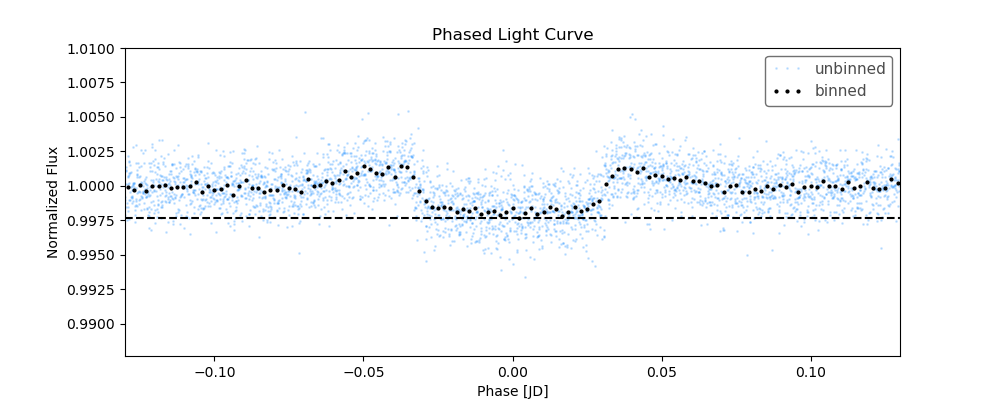

Radius:
1.9761589971969216 earthRad
0.17630140015696422 jupiterRad


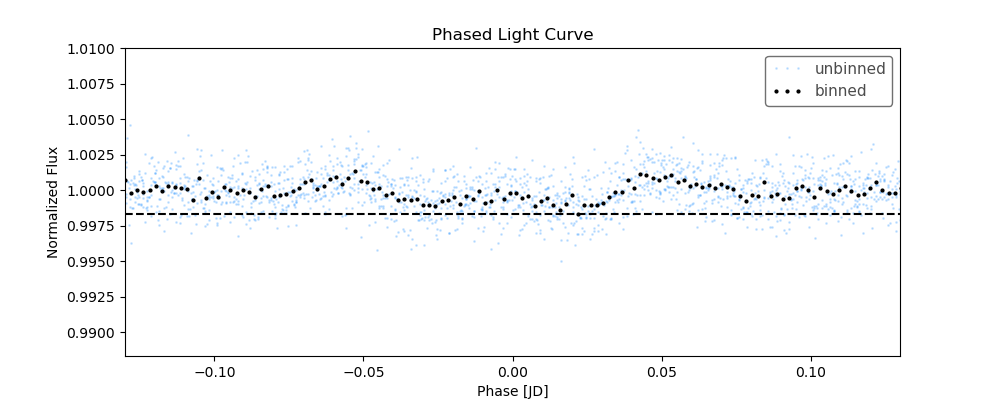

Radius:
1.6694500509245793 earthRad
0.14893861368827366 jupiterRad


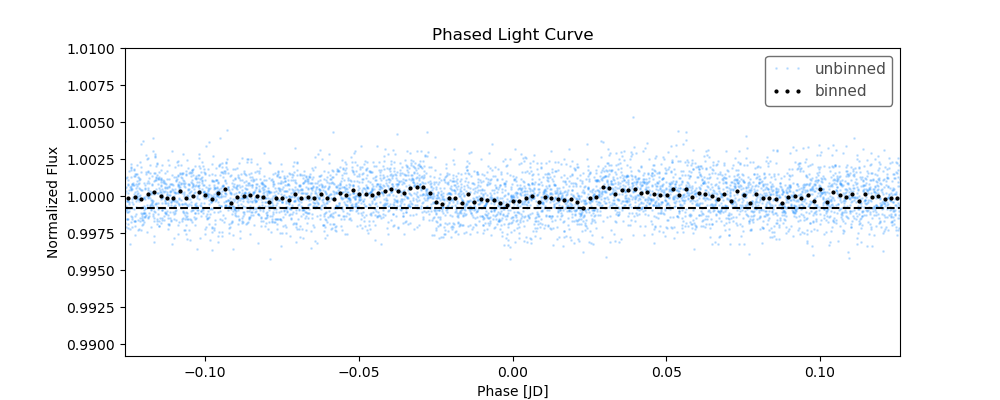

Radius:
1.148192863467722 earthRad
0.10243508228170256 jupiterRad


In [7]:
def plot_light_curve(fold_me, period, t0, duration):
    phased_lc = fold_me.fold(period = period, epoch_time = t0)
    binned_lc = phased_lc.bin(3/60/24)
    dip = binned_lc.flux.min()
    #phase_points = (-0.01 * u.day < phased_lc.phase) & (phased_lc.phase < 0.01 * u.day)
    #dip = np.mean(phased_lc.flux[phase_points])
    depth = 1 - dip.value
    half_duration = duration.value/2
    
    fig, ax = plt.subplots(figsize = (10,4))
    phased_lc.plot(ax = ax, linewidth = '0', marker = ".", color = "dodgerblue", alpha = .2, label = "unbinned")
    binned_lc.plot(ax = ax, linewidth = '0', marker = 'o', color = "black", label = "binned")
    plt.axhline(dip, color = 'black', linestyle = '--')
    plt.title("Phased Light Curve")
    plt.xlim(-(half_duration + .1), (half_duration + .1))
    plt.ylim(dip - .01, 1.01)
    plt.show()
    return depth

def find_radius(TIC, depth):
    star = Catalogs.query_object(TIC, catalog = "TIC")
    exo_sun_rad = np.sqrt(depth) * (star["rad"][0] * u.R_sun)
    exo_earth_rad = exo_sun_rad.to(u.Rearth) 
    # averge skew caused by bls, flattening, stellar data, cadence, etc.
    if exo_earth_rad > (6 * u.Rearth):
        avg_skew = .08
    elif exo_earth_rad > (2 * u.Rearth):
        avg_skew = .04
    else:
        avg_skew = 0
    exo_earth_rad = exo_sun_rad.to(u.Rearth) * (1 - avg_skew)
    exo_jupiter_rad = exo_sun_rad.to(u.Rjupiter) * (1 - avg_skew)  
    
    print('Radius:')
    print(exo_earth_rad)
    print(exo_jupiter_rad)
    return exo_earth_rad
    
for each in exoplanets:
    depth = plot_light_curve(fold_me, each["period"], each["t0"], each["duration"])
    try:
        radius = find_radius(TIC, depth)
    except:
        print("MAST import error: try again to calculate radius")
        
for i in range(len(exoplanets)):
    exoplanets[i]["depth"] = depth
    exoplanets[i]["radius"] = radius

#### Ideas for improvement
- test false positives
- compare results with exoplanet archive
- add input option for kepler KIC
- refine radius calculations for small planets
- semi-major axis
- inclination